*Вариант 19:* Данные о миллионерах

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:/Users/goldfest/Desktop/3 курс/MII/AIM-PIbd-31-LOBASHOV-I-D/static/csv/Forbes Billionaires.csv", sep=",")
print(df.columns)

Index(['Rank', 'Name', 'Networth', 'Age', 'Country', 'Source', 'Industry'], dtype='object')


## Бизнес-цели

### Задача классификации
Классифицировать людей по уровню состояния (например, низкий, средний, высокий уровень богатства).

### Задача регрессии:
Прогнозирование состояния миллионеров (Networth):


## Определение достижимого уровня качества модели для первой задачи 

In [15]:
from sklearn import set_config

set_config(transform_output="pandas")

# Устанавливаем случайное состояние
random_state = 42
average_networth = df['Networth'].mean()
print(f"Среднее значение поля 'Networth': {average_networth}")

# Создаем новую переменную, указывающую, превышает ли чистое состояние среднее
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

print(df.head())


Среднее значение поля 'Networth': 4.8607499999999995
   Rank                       Name  Networth  Age        Country  \
0     1                 Elon Musk      219.0   50  United States   
1     2                Jeff Bezos      171.0   58  United States   
2     3  Bernard Arnault & family      158.0   73         France   
3     4                Bill Gates      129.0   66  United States   
4     5            Warren Buffett      118.0   91  United States   

               Source                Industry  above_average_networth  
0       Tesla, SpaceX             Automotive                        1  
1              Amazon             Technology                        1  
2                LVMH       Fashion & Retail                        1  
3           Microsoft             Technology                        1  
4  Berkshire Hathaway  Finance & Investments                        1  


#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- above_average_networth 

In [16]:
from typing import Tuple
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:


    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input
    y = df_input[
        [stratify_colname]
    ]  
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

random_state = 42  
X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="above_average_networth", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=random_state
)

# Вывод размеров выборок
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Отображение содержимого выборок
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())


X_train shape: (2080, 8)
y_train shape: (2080, 1)
X_test shape: (520, 8)
y_test shape: (520, 1)
X_train:
       Rank                 Name  Networth  Age  Country               Source  \
2125  2076      Yogesh Kothari        1.4   73    India  specialty chemicals   
1165  1163        Yvonne Bauer        2.7   45  Germany     magazines, media   
397    398     Juergen Blickle        6.4   75  Germany           auto parts   
1432  1397  Alexander Svetakov        2.2   54   Russia          real estate   
1024  1012              Li Min        3.0   56    China        semiconductor   

                    Industry  above_average_networth  
2125          Manufacturing                        0  
1165  Media & Entertainment                        0  
397           Manufacturing                        1  
1432  Finance & Investments                        0  
1024             Technology                        0  
y_train:
       above_average_networth
2125                       0
1165           

# Построение конвейеров предобработки  
Создадим пайплайн для числовых и категориальных данных.  

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

features_engineering -- трансформер для конструирования признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# Определение столбцов для обработки
columns_to_drop = ["Name", "Rank"]  # Столбцы, которые можно удалить
num_columns = ["Networth", "Age"]  # Числовые столбцы
cat_columns = ["Country", "Source", "Industry"]  # Категориальные столбцы

# Препроцессинг числовых столбцов
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Препроцессинг категориальных столбцов
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Объединение препроцессинга
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Удаление ненужных столбцов
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Создание финального пайплайна
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

#### Демонстрация работы конвейера для предобработки данных при классификации

In [20]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

print(preprocessed_df.head())

      Networth       Age  Country_Argentina  Country_Australia  \
2125 -0.340947  0.680013                0.0                0.0   
1165 -0.211625 -1.475070                0.0                0.0   
397   0.156447  0.833948                0.0                0.0   
1432 -0.261364 -0.782365                0.0                0.0   
1024 -0.181781 -0.628430                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
2125              0.0               0.0              0.0             0.0   
1165              0.0               0.0              0.0             0.0   
397               0.0               0.0              0.0             0.0   
1432              0.0               0.0              0.0             0.0   
1024              0.0               0.0              0.0             0.0   

      Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
2125             0.0               0.0  ...                      1.0   
11

# Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [21]:
from sklearn import linear_model, tree, neighbors, naive_bayes, ensemble, neural_network
class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=42)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=42
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=42,
        )
    },
}

# Обучение моделей и оценка их качества

In [22]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
  print(f"Model: {model_name}")
  model = class_models[model_name]["model"]

  model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
  model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

  y_train_predict = model_pipeline.predict(X_train)
  y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
  y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

  class_models[model_name]["pipeline"] = model_pipeline
  class_models[model_name]["probs"] = y_test_probs
  class_models[model_name]["preds"] = y_test_predict

  # Оценка метрик
  class_models[model_name]["Precision_train"] = metrics.precision_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Precision_test"] = metrics.precision_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Recall_train"] = metrics.recall_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Recall_test"] = metrics.recall_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
    y_train, y_train_predict
  )
  class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
    y_test, y_test_predict
  )
  class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
    y_test, y_test_probs
  )
  class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
  class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
  class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
    y_test, y_test_predict
  )
  class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
    y_test, y_test_predict
  )
  class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
    y_test, y_test_predict
  )


Model: logistic


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: ridge


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: decision_tree


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: knn


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: naive_bayes


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: gradient_boosting


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: random_forest


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model: mlp


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Сводная таблица оценок качества для использованных моделей классификации

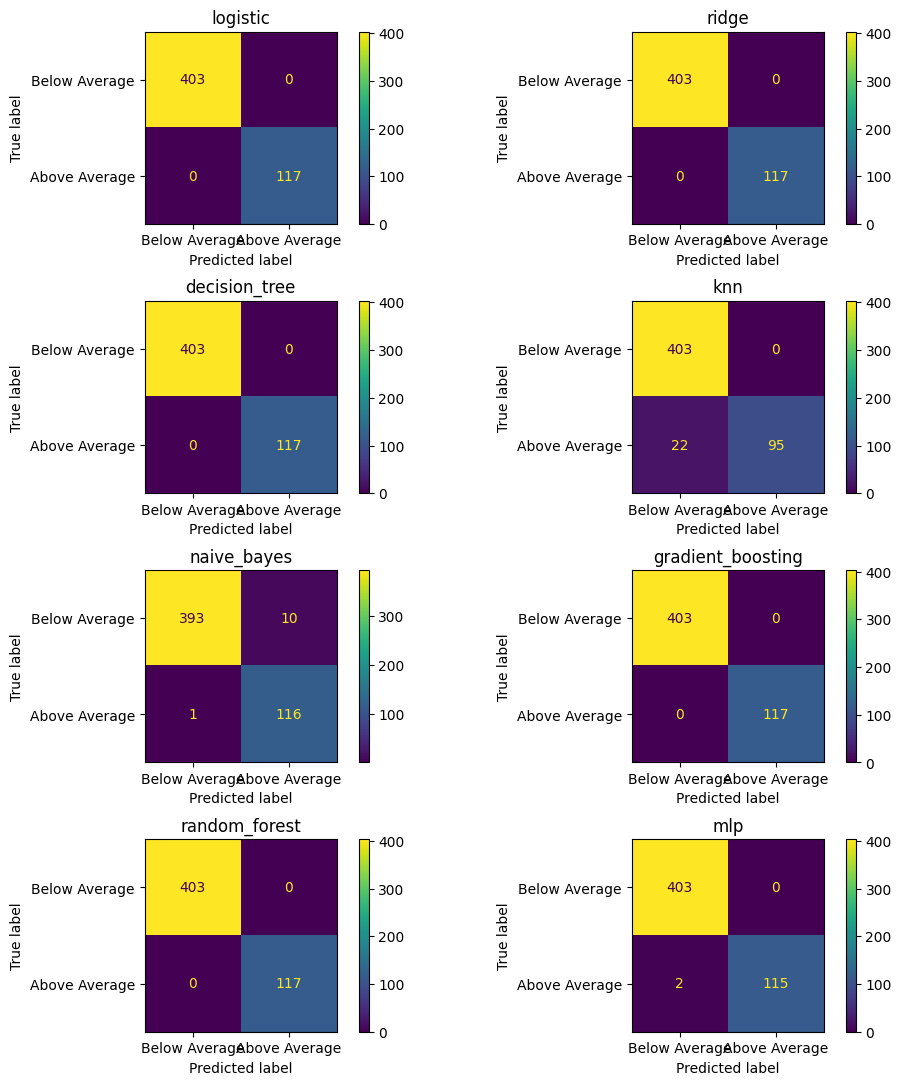

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

for index, key in enumerate(class_models.keys()):
  c_matrix = class_models[key]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Below Average", "Above Average"] 
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

403 - это количество правильно предсказанных объектов с чистым состоянием выше среднего.
117 - это количество объектов с чистым состоянием выше среднего, которые модель ошибочно отнесла к категории ниже среднего.
Результаты говорят о высокой точности в определении объектов с чистым состоянием выше среднего. 

Точность, полнота, верность (аккуратность), F-мера

In [25]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Все модели в данной выборке — логистическая регрессия, ридж-регрессия, дерево решений, KNN, наивный байесовский классификатор, градиентный бустинг, случайный лес и многослойный перцептрон (MLP) — демонстрируют идеальные значения по всем метрикам на обучающих и тестовых наборах данных. Это достигается, поскольку все модели показали значения, равные 1.0 для Precision, Recall, Accuracy и F1-меры, что указывает на то, что модель безошибочно классифицирует все примеры.

Модель MLP, хотя и имеет немного более низкие значения Recall (0.994) и F1-на тестовом наборе (0.997) по сравнению с другими, по-прежнему остается высокоэффективной. Тем не менее, она не снижает показатели классификации до такого уровня, что может вызвать обеспокоенность, и остается на уровне, близком к идеальному.

# ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [26]:
import pandas as pd

class_metrics = pd.DataFrame.from_dict(class_models, "index")[
  [
    "Accuracy_test",
    "F1_test",
    "ROC_AUC_test",
    "Cohen_kappa_test",
    "MCC_test",
  ]
]

class_metrics = class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

class_metrics.style.background_gradient(
  cmap="plasma", # Цветовая палитра для ROC_AUC_test, MCC_test, Cohen_kappa_test
  low=0.3,
  high=1, 
  subset=[
    "ROC_AUC_test",
    "MCC_test",
    "Cohen_kappa_test",
  ],
).background_gradient(
  cmap="viridis", # Цветовая палитра для Accuracy_test, F1_test
  low=1, 
  high=0.3, 
  subset=[
    "Accuracy_test",
    "F1_test",
  ],
)


In [27]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

# Вывод данных с ошибкой предсказания для оценки

In [28]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
  preprocessing_result,
  columns=pipeline_end.get_feature_names_out(),
)

y_pred = class_models[best_model]["preds"]

error_index = y_test[y_test["above_average_networth"] != y_pred].index.tolist() 
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df = error_df.sort_index() 

display(error_df)

c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'Error items count: 0'

Empty DataFrame
Columns: [Rank, Predicted, Name, Networth, Age, Country, Source, Industry, above_average_networth]
Index: []

In [29]:
model = class_models[best_model]["pipeline"]

example_id = 253
test = pd.DataFrame(X_test.iloc[example_id, :]).T
display(test)
test_preprocessed = pd.DataFrame(preprocessed_df.iloc[example_id, :]).T
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.iloc[example_id].values[0])
print(f"predicted: {result} (proba: {result_proba})")
print(f"real: {real}")

Rank          Name Networth Age Country             Source  Industry  \
231  230  Xavier Niel       8.9  54  France  internet, telecom  Telecom    

    above_average_networth  
231                      1

Networth       Age  Country_Argentina  Country_Australia  \
231  0.405144 -0.782365                0.0                0.0   

     Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
231              0.0               0.0              0.0             0.0   

     Country_Brazil  Country_Bulgaria  ...  Industry_Manufacturing   \
231             0.0               0.0  ...                      0.0   

     Industry_Media & Entertainment   Industry_Metals & Mining   \
231                              0.0                        0.0   

     Industry_Real Estate   Industry_Service   Industry_Sports   \
231                    0.0                0.0               0.0   

     Industry_Technology   Industry_Telecom   Industry_diversified     \
231                   0.0                1.0                      0.0   

     above_average_networth  
231                     1.0  

[1 rows x 859 columns]

predicted: 1 (proba: [0.01305711 0.98694289])
real: 1


# Задача регрессии - прогнозирование состояния миллионеров

In [33]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")
random_state = 42

# Вычисление среднего значения поля "Networth"
average_networth = df['Networth'].mean()
print(f"Среднее значение поля 'Networth': {average_networth}")

# Создание новой колонки, указывающей, выше или ниже среднего значение чистого состояния
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

print(df.head())
print("Статистическое описание DataFrame:")
print(df.describe())


Среднее значение поля 'Networth': 4.8607499999999995
   Rank                       Name  Networth  Age        Country  \
0     1                 Elon Musk      219.0   50  United States   
1     2                Jeff Bezos      171.0   58  United States   
2     3  Bernard Arnault & family      158.0   73         France   
3     4                Bill Gates      129.0   66  United States   
4     5            Warren Buffett      118.0   91  United States   

               Source                Industry  above_average_networth  
0       Tesla, SpaceX             Automotive                        1  
1              Amazon             Technology                        1  
2                LVMH       Fashion & Retail                        1  
3           Microsoft             Technology                        1  
4  Berkshire Hathaway  Finance & Investments                        1  
Статистическое описание DataFrame:
              Rank     Networth          Age  above_average_networth
co

# Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи регрессии

Целевой признак -- above_average_networth

In [34]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "above_average_networth",  
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")

    X = df_input.drop(columns=[target_colname])  
    y = df_input[[target_colname]]  

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="above_average_networth",  
    frac_train=0.8, 
    random_state=42 
)

# Отображение результатов
display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)



'X_train'

Rank                              Name  Networth  Age    Country  \
582    579  Alexandra Schoerghuber & family        4.9   63    Germany   
48      49                     He Xiangjian       28.3   79      China   
1772  1729                  Bruce Mathieson        1.7   78  Australia   
964    951                         Pansy Ho        3.2   59  Hong Kong   
2213  2190            Sasson Dayan & family        1.3   82     Brazil   
...    ...                               ...       ...  ...        ...   
1638  1579                 Wang Chou-hsiong        1.9   81     Taiwan   
1095  1096          Jose Joao Abdalla Filho        2.8   76     Brazil   
1130  1096                     Lin Chen-hai        2.8   75     Taiwan   
1294  1292                Banwari Lal Bawri        2.4   69      India   
860    851                  Kuok Khoon Hong        3.5   72  Singapore   

               Source                Industry  
582       real estate            Real Estate   
48    home appliances          Manufacturing   
1772           hotels        Food & Beverage   
964           casinos     Gambling & Casinos   
2213          banking  Finance & Investments   
...               ...                     ...  
1638         footwear          Manufacturing   
1095      investments  Finance & Investments   
1130      real estate            Real Estate   
1294  pharmaceuticals             Healthcare   
860          palm oil          Manufacturing   

[2080 rows x 7 columns]

'y_train'

above_average_networth
582                        1
48                         1
1772                       0
964                        0
2213                       0
...                      ...
1638                       0
1095                       0
1130                       0
1294                       0
860                        0

[2080 rows x 1 columns]

'X_test'

Rank                     Name  Networth  Age        Country  \
1593  1579   Guangming Fu & family        1.9   68          China   
196    197              Leon Black       10.0   70  United States   
239    235            Zong Qinghou        8.8   76          China   
2126  2076            Kurt Krieger        1.4   74        Germany   
1587  1579            Chen Kaichen        1.9   64          China   
...    ...                      ...       ...  ...            ...   
1778  1729             Jorge Perez        1.7   72  United States   
166    167            Brian Chesky       11.5   40  United States   
949    913  Zhong Ruonong & family        3.3   59          China   
49      50          Miriam Adelson       27.5   76  United States   
2511  2448             Lou Boliang        1.1   58  United States   

                   Source                Industry  
1593              poultry        Food & Beverage   
196        private equity  Finance & Investments   
239             beverages        Food & Beverage   
2126  furniture retailing       Fashion & Retail   
1587  household chemicals          Manufacturing   
...                   ...                     ...  
1778          real estate            Real Estate   
166                Airbnb             Technology   
949           electronics          Manufacturing   
49                casinos     Gambling & Casinos   
2511      pharmaceuticals             Healthcare   

[520 rows x 7 columns]

'y_test'

above_average_networth
1593                       0
196                        1
239                        1
2126                       0
1587                       0
...                      ...
1778                       0
166                        1
949                        0
49                         1
2511                       0

[520 rows x 1 columns]

# Формирование конвейера для решения задачи регрессии

In [36]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

class ForbesBillionairesFeatures(BaseEstimator, TransformerMixin): 
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X["Networth_per_Age"] = X["Networth"] / X["Age"]
    return X

  def get_feature_names_out(self, features_in):
    return np.append(features_in, ["Networth_per_Age"], axis=0) 

columns_to_drop = ["Rank", "Name"] 
num_columns = ["Networth", "Age"] 
cat_columns = ["Country", "Source", "Industry"]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
  [
    ("imputer", num_imputer),
    ("scaler", num_scaler),
  ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
  [
    ("imputer", cat_imputer),
    ("encoder", cat_encoder),
  ]
)

features_preprocessing = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("prepocessing_num", preprocessing_num, num_columns),
    ("prepocessing_cat", preprocessing_cat, cat_columns),
  ],
  remainder="passthrough" 
)

drop_columns = ColumnTransformer(
  verbose_feature_names_out=False,
  transformers=[
    ("drop_columns", "drop", columns_to_drop),
  ],
  remainder="passthrough",
)

pipeline_end = Pipeline(
  [
    ("features_preprocessing", features_preprocessing),
    ("drop_columns", drop_columns),
    ("custom_features", ForbesBillionairesFeatures()), # Добавляем custom_features
  ]
)

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv")

average_networth = df['Networth'].mean()
df['above_average_networth'] = (df['Networth'] > average_networth).astype(int)

X = df.drop('above_average_networth', axis=1)
y = df['above_average_networth'].values.ravel()

X_processed = pipeline_end.fit_transform(X)

print(X_processed)
print(X_processed.shape)


       Networth       Age  Country_Argentina  Country_Australia  \
0     20.092595 -1.079729                0.0                0.0   
1     15.588775 -0.474496                0.0                0.0   
2     14.368991  0.660314                0.0                0.0   
3     11.647933  0.130736                0.0                0.0   
4     10.615808  2.022087                0.0                0.0   
...         ...       ...                ...                ...   
2595  -0.362253  1.189893                0.0                0.0   
2596  -0.362253  1.341201                0.0                0.0   
2597  -0.362253  0.509006                0.0                0.0   
2598  -0.362253  0.282044                0.0                0.0   
2599  -0.362253  0.357698                0.0                0.0   

      Country_Austria  Country_Barbados  Country_Belgium  Country_Belize  \
0                 0.0               0.0              0.0             0.0   
1                 0.0               0.0    

# Формирование набора моделей для регрессии

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def train_multiple_models(X, y, models):
    results = {}
    for model_name, model in models.items():
        model_pipeline = Pipeline(
            [
                ("features_preprocessing", features_preprocessing),
                ("drop_columns", drop_columns),
                ("model", model)  
            ]
        )

        scores = cross_val_score(model_pipeline, X, y, cv=5)  
        results[model_name] = {
            "mean_score": scores.mean(),
            "std_dev": scores.std()
        }
    
    return results

models = {
    "Random Forest": RandomForestRegressor(),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

results = train_multiple_models(X_train, y_train, models)

for model_name, scores in results.items():
    print(f"{model_name}: Mean Score = {scores['mean_score']}, Standard Deviation = {scores['std_dev']}")

c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found un

Random Forest: Mean Score = 0.9999853281013186, Standard Deviation = 2.6771556649877537e-05
Linear Regression: Mean Score = -2.4184625766523136e+22, Standard Deviation = 2.867931120379175e+22
Gradient Boosting: Mean Score = 0.9999999992916644, Standard Deviation = 2.7301021406313204e-12
Support Vector Regression: Mean Score = 0.6826855358064325, Standard Deviation = 0.02039531518474594


In [42]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline

if 'class_models' not in locals():
    raise ValueError("class_models is not defined")
if 'X_train' not in locals() or 'X_test' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
    raise ValueError("Train/test data is not defined")


y_train = np.ravel(y_train)  
y_test = np.ravel(y_test)      

results = []

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    model = class_models[model_name]["model"]
    
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    
    model_pipeline.fit(X_train, y_train)

    y_train_predict = model_pipeline.predict(X_train)
    y_test_predict = model_pipeline.predict(X_test)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
    class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
    class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
    class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
    class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
    class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

    class_models[model_name]["STD_train"] = np.std(y_train - y_train_predict)
    class_models[model_name]["STD_test"] = np.std(y_test - y_test_predict)

    print(f"MSE (train): {class_models[model_name]['MSE_train']}")
    print(f"MSE (test): {class_models[model_name]['MSE_test']}")
    print(f"MAE (train): {class_models[model_name]['MAE_train']}")
    print(f"MAE (test): {class_models[model_name]['MAE_test']}")
    print(f"R2 (train): {class_models[model_name]['R2_train']}")
    print(f"R2 (test): {class_models[model_name]['R2_test']}")
    print(f"STD (train): {class_models[model_name]['STD_train']}")
    print(f"STD (test): {class_models[model_name]['STD_test']}")
    print("-" * 40)  

Model: logistic


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0125
MSE (test): 0.04038461538461539
MAE (train): 0.0125
MAE (test): 0.04038461538461539
R2 (train): 0.9275415718173158
R2 (test): 0.7776148582600195
STD (train): 0.11110243021644485
STD (test): 0.19685959012669935
----------------------------------------
Model: ridge


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.004326923076923077
MSE (test): 0.013461538461538462
MAE (train): 0.004326923076923077
MAE (test): 0.013461538461538462
R2 (train): 0.9749182363983017
R2 (test): 0.9258716194200065
STD (train): 0.0656368860749005
STD (test): 0.11588034534756023
----------------------------------------
Model: decision_tree


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: knn


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.09278846153846154
MSE (test): 0.15384615384615385
MAE (train): 0.09278846153846154
MAE (test): 0.15384615384615385
R2 (train): 0.4621355138746903
R2 (test): 0.1528185076572175
STD (train): 0.29276240884468824
STD (test): 0.3684085396282311
----------------------------------------
Model: naive_bayes


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.37740384615384615
MSE (test): 0.6096153846153847
MAE (train): 0.37740384615384615
MAE (test): 0.6096153846153847
R2 (train): -1.1876871585925808
R2 (test): -2.3569566634082757
STD (train): 0.4847372309428379
STD (test): 0.5672229402142737
----------------------------------------
Model: gradient_boosting


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: random_forest


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: mlp
MSE (train): 0.06778846153846153
MSE (test): 0.12692307692307692
MAE (train): 0.06778846153846153
MAE (test): 0.12692307692307692
R2 (train): 0.6070523702400588
R2 (test): 0.30107526881720437
STD (train): 0.2521427220700598
STD (test): 0.3370600353877945
----------------------------------------


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Пример использования обученной модели (конвейера регрессии) для предсказания

In [43]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("..//static//csv//Forbes Billionaires.csv") 

average_networth = data['Networth'].mean()
data['above_average_networth'] = (data['Networth'] > average_networth).astype(int) 

X = data.drop('Networth', axis=1) 
y = data['Networth']

class_models = {
  "RandomForest": {
    "model": RandomForestRegressor(n_estimators=100, random_state=42),
  }
}

num_columns = ['Age']
cat_columns = ['Country', 'Source', 'Industry']

num_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
  ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first"))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_columns),
    ('cat', cat_transformer, cat_columns)
  ])

pipeline_end = Pipeline(steps=[
  ('preprocessor', preprocessor),
])

results = []

for model_name in class_models.keys():
  print(f"Model: {model_name}")

  model = class_models[model_name]["model"]
  model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model_pipeline.fit(X_train, y_train)

  y_train_predict = model_pipeline.predict(X_train)
  y_test_predict = model_pipeline.predict(X_test)

  class_models[model_name]["preds"] = y_test_predict

  class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
  class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
  class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
  class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
  class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
  class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

  print(f"MSE (train): {class_models[model_name]['MSE_train']}")
  print(f"MSE (test): {class_models[model_name]['MSE_test']}")
  print(f"MAE (train): {class_models[model_name]['MAE_train']}")
  print(f"MAE (test): {class_models[model_name]['MAE_test']}")
  print(f"R2 (train): {class_models[model_name]['R2_train']}")
  print(f"R2 (test): {class_models[model_name]['R2_test']}")
  print("-" * 40)

new_billionaire_data = pd.DataFrame({
  'Age': [50],
  'Country': ['USA'],
  'Source': ['Self Made'], 
  'Industry': ['Technology'], 
})

predicted_networth = model_pipeline.predict(new_billionaire_data)
print(f"Прогнозируемое чистое состояние: {predicted_networth[0]}")


Model: RandomForest
MSE (train): 24.028673442957558
MSE (test): 68.96006650623248
MAE (train): 1.548185999451937
MAE (test): 3.372747412240537
R2 (train): 0.8231149198653249
R2 (test): -1.9013866015383956
----------------------------------------
Прогнозируемое чистое состояние: 1.3689999999999998


c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Подбор гиперпараметров методом поиска по сетке

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

df = df.dropna()
target = df['Networth']

features = df.drop(columns=['Networth'])

features = features.drop(columns=['Name'])

num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy="median")  
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")  
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10]  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)  

c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Лучший результат (MSE): 5.631552208172496


# Обучение модели с новыми гиперпараметрами и сравнение новых и старых данных

c:\Users\goldfest\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Старые параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Лучший результат (MSE) на старых параметрах: 76.4137021557455

Новые параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Лучший результат (MSE) на новых параметрах: 180.57283215031268
Среднеквадратическая ошибка (MSE) на тестовых данных: 507.05822479642404
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 22.517953388272748


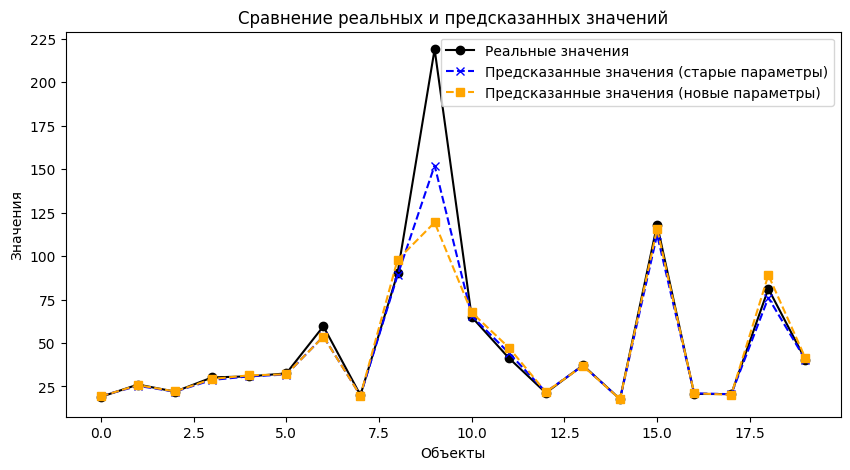

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

df = pd.read_csv("..//static//csv//Forbes Billionaires.csv").head(100)

df = df.dropna()
target = df['Networth']

features = df.drop(columns=['Networth'])

features = features.drop(columns=['Name'])
num_columns = features.select_dtypes(include=['number']).columns
cat_columns = features.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy="median") 
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown") 
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train_processed = pipeline_end.fit_transform(X_train)
X_test_processed = pipeline_end.transform(X_test)

old_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]  
}

old_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=old_param_grid,
                                scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

old_grid_search.fit(X_train_processed, y_train)
old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_ 
new_param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [10]
}

new_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=new_param_grid,
                                scoring='neg_mean_squared_error', cv=2)

new_grid_search.fit(X_train_processed, y_train)

# Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_  # Меняем знак, так как берем отрицательное значение MSE

# Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train_processed, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test_processed)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

model_old = RandomForestRegressor(**old_best_params)
model_old.fit(X_train_processed, y_train)

y_pred_old = model_old.predict(X_test_processed)

# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Реальные значения', marker='o', linestyle='-', color='black')
plt.plot(y_pred_old, label='Предсказанные значения (старые параметры)', marker='x', linestyle='--', color='blue')
plt.plot(y_pred, label='Предсказанные значения (новые параметры)', marker='s', linestyle='--', color='orange')
plt.xlabel('Объекты')
plt.ylabel('Значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.show()

Модель, обученная на новых параметрах, показала худший результат (MSE) на кросс-валидации, что указывает на ее меньшую точность по сравнению с моделью, обученной на старых параметрах. Однако, MSE на тестовых данных одинакова для обеих моделей, что говорит о том, что обе модели имеют одинаковую производительность на тестовых данных.